In [1]:
from tl import preprocess
from src import helperfuncs

import time
import os
from pathlib import Path
import numpy as np

start_time = time.time()

folderPath = 'C:/My Documents/TUD-MCL/Semester 4/Thesis/Implementation/Data/Dataset-1/'
imgName = '18_04_27_Thomas_28618_0017.dm3'

dirname = 'C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser'
templatesPath = Path(dirname + "/data/" + 'alltemplates'+ imgName +'.pickle')

stride=6
templateSize=48

imgs = helperfuncs.loadData(folderPath, imgName)

allTemplates = preprocess.createTemplates(imgs, stride, templateSize, templatesPath)

In [2]:
import random

def getperm(l):
    seed = len(l)*3
    random.seed(seed)
    perm = list(range(len(l)))
    random.shuffle(perm)
    random.seed() # optional, in order to not impact other code based on random
    return perm

def shuffle(l):
    perm = getperm(l)
    l[:] = [l[j] for j in perm]

def unshuffle(l):
    perm = getperm(l)
    res = [None] * len(l)
    for i, j in enumerate(perm):
        res[j] = l[i]
    l[:] = res

In [3]:
shuffle(allTemplates)

In [4]:
allTemplates = np.array(allTemplates)
print(allTemplates.shape)

(6084, 48, 48)


In [5]:
allTemplates = allTemplates[:,:,:,np.newaxis]
# np.random.shuffle(allTemplates)

maxVal = np.max(allTemplates)
allTemplates = allTemplates.astype("float32")/maxVal

train_len = int(np.floor(allTemplates.shape[0]*0.8))
train = allTemplates[:train_len,:,:,:]
test = allTemplates[train_len:,:,:,:]

print(allTemplates.shape)


(6084, 48, 48, 1)


In [6]:
train.shape

(4867, 48, 48, 1)

In [7]:
from tl import tldenoise
from tensorflow import keras

model_name = 'model_shuffle_inputs'+imgName

try:
    autoencoder = keras.models.load_model('C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser/model/'+model_name+'.h5')
    autoencoder.summary()
except IOError:
    print("No saved model found")
    autoencoder = tldenoise.buildModel()
    autoencoder.fit(
        x=train,
        y=train[:,22:26,22:26,:],
        epochs=10,
        batch_size=128,
        shuffle=True,
        validation_data=(test, test[:,22:26,22:26,:]),
    )
    autoencoder.save('C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser/model/'+model_name+'.h5')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 48, 48, 32)        9248

In [8]:
allTemplates = list(allTemplates)
print(len(allTemplates))
print(allTemplates[0].shape)

6084
(48, 48, 1)


In [9]:
unshuffle(allTemplates)
print(len(allTemplates))
print(allTemplates[0].shape)

6084
(48, 48, 1)


In [22]:
allTemplates = np.array(allTemplates)

predictions = autoencoder.predict(allTemplates[:,:,:,:])

predictions = predictions[:,:,:,:]*maxVal

In [12]:
imgs[0].shape
inputdata = imgs[0]
inputdata = inputdata[np.newaxis,:,:,np.newaxis]
inputdata = inputdata.astype("float32")/np.max(imgs[0])
predictions = autoencoder.predict(inputdata)
predictions = predictions * np.max(imgs[0])


In [18]:
np.max(predictions)
predictions.shape

(1, 468, 468, 1)

TypeError: list indices must be integers or slices, not tuple

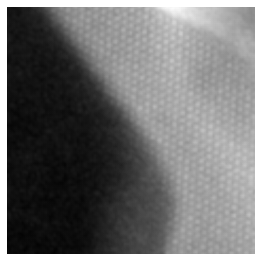

In [13]:
import matplotlib.pyplot as plt

pos = 0

predictions_disp = predictions[pos,:,:,:]*maxVal

   
plt.figure(figsize=(5, 5*2)) 

vstd=np.std(predictions_disp)
vmean=np.mean(predictions_disp)         
ax1=plt.subplot(2,1,1)
ax1.imshow(predictions_disp,cmap='gray',vmin=np.min(predictions_disp),vmax=np.max(predictions_disp))
ax1.axis('off')

disp = allTemplates[pos,:,:,:]*maxVal

vstd=np.std(test)
vmean=np.mean(disp)         
ax1=plt.subplot(2,1,2)
ax1.imshow(disp,cmap='gray',vmin=np.min(disp),vmax=np.max(disp))
ax1.axis('off')


In [32]:
np.min(imgs)

1169248.0

In [33]:
np.max(imgs)

3282827.0

In [23]:
# generating a smooth transistion map:
backplotwindow=np.zeros((templateSize, templateSize))
x = np.linspace(0, 1, backplotwindow.shape[0])
y = np.linspace(0, 1,  backplotwindow.shape[1])
xv, yv = np.meshgrid(x, y, sparse=True)
backplotwindow=np.exp(-((4*np.maximum(0,(xv-0.5))**2-0.1)+(4*np.maximum(0,(yv-0.5))**2-0.1)))   


# n=0
# pltminradius=3

    
overlay=[]
overlayCount=[]
overlayclass=[]

for i in range(len(imgs)):
    img = imgs[i]
    overlay.append(np.zeros(img.shape))
    overlayCount.append(np.zeros(img.shape))

n=0

for o in range(0,len(overlay)):
    for x in range(0, imgs[o].shape[0]-templateSize, stride):
        for y in range(0, imgs[o].shape[1]-templateSize, stride):
            predicted_template = predictions[n,:,:,0]
            overlay[o][x:(x+templateSize),y:(y+templateSize)]+=predicted_template*backplotwindow
            overlayCount[o][x:(x+templateSize),y:(y+templateSize)]+=backplotwindow
            n+=1
            
imgBackplots = []
mymin=[]
mymax=[]
for i in range(len(imgs)):
    imgBackplots.append(overlay[i]/ ( overlayCount[i] + (np.double(overlayCount[i]==0))  ) ) 
    mymin.append(np.min(imgBackplots[i][imgBackplots[i]>np.min(imgBackplots[i][imgBackplots[i]>0])]))
    mymax.append(np.max(imgBackplots[i][imgBackplots[i]>0]))

In [32]:
import random

x = random.sample(range(0, 512-templateSize), 25)
y = random.sample(range(0, 512-templateSize), 25)

startPosList = []
for i in range(len(x)):
    startPosList.append([x[i],y[i]])

In [14]:
import matplotlib.pyplot as plt

(48, 48, 1)


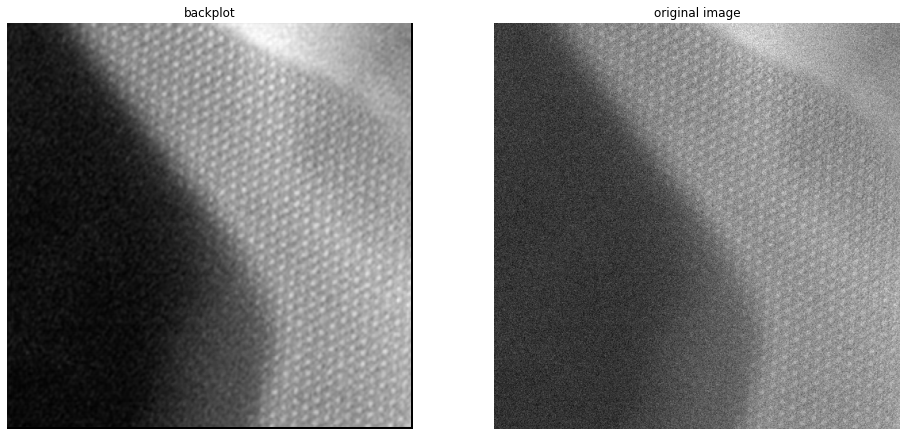

In [26]:
for i in range(len(imgs)):
    print(predictions[i].shape)
    plt.figure(figsize=(2*8, 2*4)) 
    ax1=plt.subplot(1,2,1)                    
    ax1.imshow(imgBackplots[i],cmap=plt.cm.gray,vmin = mymin[i], vmax = mymax[i])
    ax1.set_title('backplot')
    ax1.axis('off')
    ax2=plt.subplot(1,2,2)                    
    ax2.imshow(imgs[i],cmap=plt.cm.gray)
    ax2.set_title('original image')
    ax2.axis('off')
    #plt.figure(figsize=(15, 12))  
    #plt.imshow(overlayclass[Mode][myindex],cmap=plt.cm.gist_rainbow)
    #plt.colorbar()
    plt.show()

In [17]:
print(imgBackplots[0].shape)

(512, 512)


In [18]:
from src import helperfuncs
from src import classify
from src import cluster

templates = helperfuncs.generateTemplates(startPosList=startPosList, imgs=imgBackplots, radius=templateSize//2)
templates = classify.tempfuncname(radius=templateSize//2, imgs=imgBackplots, templates=templates, maxNumberInClass=100, minNumberInClass=4)
backplot_new, mymin, mymax, templateMatchingResults = classify.backplotImg(templateSize//2, imgBackplots, templates)

picDic = cluster.sortTemplates(imgBackplots, templateMatchingResults, templateSize//2, templates)
centroidDic = cluster.cluster(templateSize//2, templates, picDic)

backplotFinal, mymin, mymax = cluster.backplotFinal(centroidDic, picDic, imgBackplots, templateSize//2, templateMatchingResults)    


Used 987subimages
Used 987subimages
Used 987subimages


(512, 512)


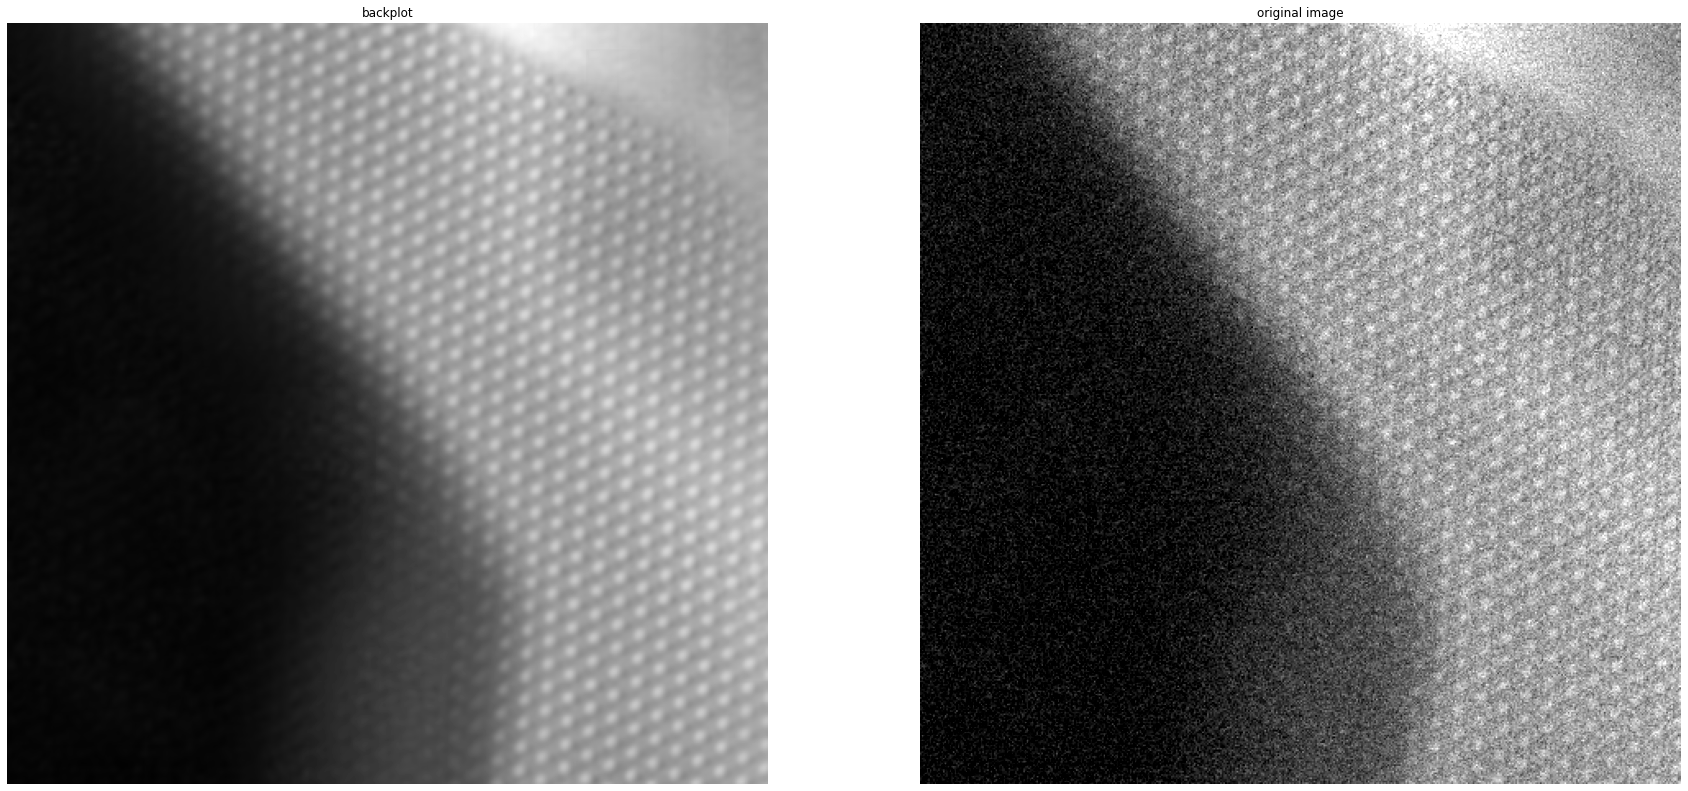

In [22]:
for i in range(len(imgs)):
    print(backplotFinal[i].shape)
    radius = templateSize//2
    plt.figure(figsize=(2*15, 2*7)) 
    ax1=plt.subplot(1,2,1)                    
    ax1.imshow(backplotFinal[i][radius:-radius,radius:-radius],cmap=plt.cm.gray,vmin=mymin[i],vmax=mymax[i])
    ax1.set_title('backplot')
    ax1.axis('off')
    ax2=plt.subplot(1,2,2)                    
    ax2.imshow(imgs[i][radius:-radius,radius:-radius],cmap=plt.cm.gray,vmin=mymin[i],vmax=mymax[i])
    ax2.set_title('original image')
    ax2.axis('off')
    #plt.figure(figsize=(15, 12))  
    #plt.imshow(overlayclass[Mode][myindex],cmap=plt.cm.gist_rainbow)
    #plt.colorbar()
    # plt.show()

plt.savefig('C:/My Documents/TUD-MCL/Semester 4/Thesis/repo/img-denoiser/nn-results/'+imgName+'-denoised.png')  

Text(0.5, 1.0, 'FFT of denoised image in')

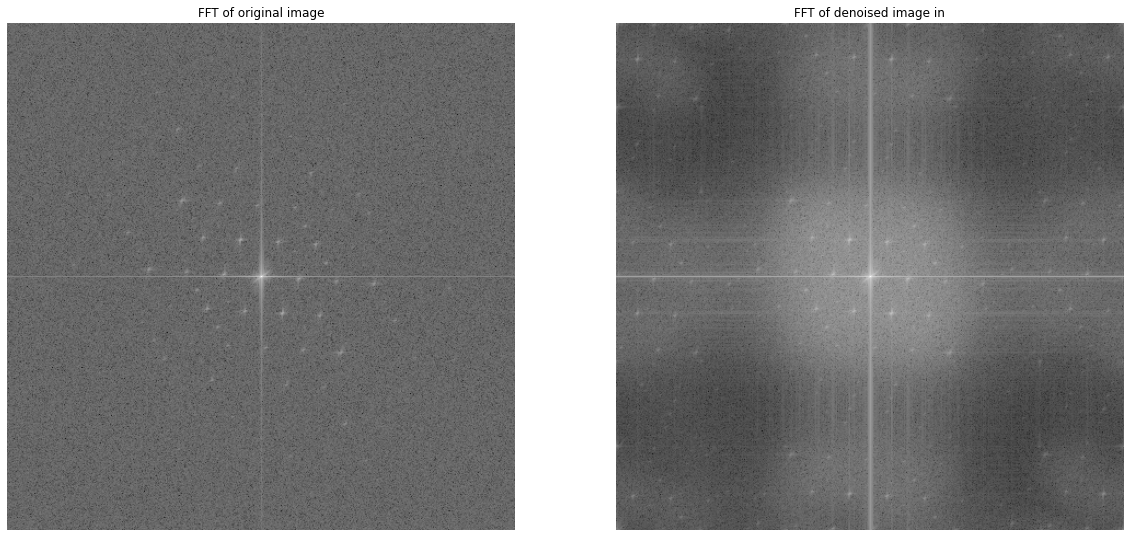

In [31]:
plt.figure(figsize=(20,20))

radius = 24

img = np.log(np.abs(np.fft.fftshift(np.fft.fft2(imgs[0][radius:-radius,radius:-radius]))))
ax1=plt.subplot(1,2,1)
ax1.imshow(img,cmap='gray')
ax1.axis('off')
ax1.set_title('FFT of original image')
img = np.log(np.abs(np.fft.fftshift(np.fft.fft2(imgBackplots[0][radius:-radius,radius:-radius]))))
ax1=plt.subplot(1,2,2)
ax1.imshow(img,cmap='gray')
ax1.axis('off')
ax1.set_title('FFT of denoised image in')

# plt.savefig(resultPath + 'fft.png' )

In [11]:
import numpy as np

data = np.floor(np.random.rand(3,2,4)*10)

array([[[7., 3., 5., 7.],
        [5., 4., 6., 4.]],

       [[3., 4., 7., 7.],
        [0., 4., 2., 7.]],

       [[2., 6., 7., 3.],
        [1., 1., 6., 0.]]])

In [12]:
np.amax(data, axis=0)

array([[7., 6., 7., 7.],
       [5., 4., 6., 7.]])

In [13]:
np.argmax(data, axis=0)

array([[0, 2, 1, 0],
       [0, 0, 0, 1]], dtype=int64)